## Who Survived "The Titanic" ?

Data Source : https://www.kaggle.com/c/titanic/download/train.csv

Read the data from the file into pandas dataframe. Analyze, clean and transform the data to answer the following question:

What categories of passengers were most likely to survive the Titanic disaster?
You might include the following attributes in your analysis:

Passenger age,
Passenger gender,
Cabin class the passenger traveled in (variable ‘ticket class’).
What other attributes did you use for the analysis? Explain how you used them.Provide a complete list of all attributes used.

Did you engineer any attributes? If yes, explain the rationale and how the new attributes were used in the analysis?

If you have excluded any attributes from the analysis, provide an explanation why you believe they can be excluded.

How did you treat missing values? Provide the detailed explanation in the comments.

In [4]:
# the standard boilerplate stuff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from IPython.display import HTML, display
from pandas import Series, DataFrame


In [111]:
# turn off matplotlib interactive mode
plt.ioff()

Lets load the file and look into the contents of first few rows

In [112]:
# Read the file
raw_df = pd.read_csv("train.csv")
raw_df.name = "Titanic Passenger Data"

# Structure of the raw data
display(HTML(raw_df.head().to_html()))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Lets look the columns and number of rows with valid data

In [113]:
# basic info on the features
raw_df.info()

print()
print("Survived Unique Values",raw_df["Survived"].unique(), sep=" : ")
print("Passenger Class Unique Values",raw_df["Pclass"].unique(), sep=" : ")
print("Sex Unique Values",raw_df["Sex"].unique(), sep=" : ")
print("Age Range : ",raw_df["Age"].min(), "-", raw_df["Age"].max())
print("Siblings/Spouse Unique Values",raw_df["SibSp"].unique(), sep=" : ")
print("Parents/Children Unique Values",raw_df["Parch"].unique(), sep=" : ")
print("Fare Range : ",raw_df["Fare"].min(), "-", raw_df["Fare"].max())
print("Embarked Unique Values",raw_df["Embarked"].unique(), sep=" : ")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

Survived Unique Values : [0 1]
Passenger Class Unique Values : [3 1 2]
Sex Unique Values : ['male' 'female']
Age Range :  0.42 - 80.0
Siblings/Spouse Unique Values : [1 0 3 4 2 5 8]
Parents/Children Unique Values : [0 1 2 5 3 4 6]
Fare Range :  0.0 - 512.3292
Embarked Unique Values : ['S' 'C' 'Q' nan]


## Original Attributes

So we have the following initial attributes:
    <br>
    a) <b>Passenger Id</b> : unique identifier for passenger
    <br>
    b) <b>Survived</b> : 0 -> Died, 1 -> Survived
    <br>
    c) <b>Pclass</b> : Indicates Passenger Class. Has values 1,2,3 indicating 1st, 2nd and 3rd class
    <br>
    d) <b>Name</b> : Passenger Name
    <br>
    e) <b>Sex</b> : male/female
    <br>
    f) <b>Age</b> : Numeric value indicating age in years
    <br>
    g) <b>SibSp</b> : indicates number of siblings/spouse travelling with the passenger
    <br>
    h) <b>Parch</b> : indicates number of parents/children travelling with the passenger
    <br>
    i) <b>Ticket</b> : The ticket number
    <br>
    j) <b>Fare</b> : Fare paid
    <br>
    k) <b>Cabin</b> : The cabin number
    <br>
    l) <b>Embarked</b> : The boarding port ( S -> Southampton, C -> Cherbourg, Q -> Queenstown)

Lets look at some of the data to identify patterns :

a) Name

In [114]:
display(HTML(raw_df[['Name']].head().to_html()))

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


Clearly the names are in the format : {Surname}, {Title}. {Name} (Alias)
We can parse the names to extract the salutations/titles and family names

b) Cabin



In [115]:
cabins = raw_df[['Cabin']]
cabins = cabins[cabins['Cabin'].notnull()]
display(HTML(cabins.head().to_html()))

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103


Clearly the cabins have an alphabetic prefix and a numeric suffix

If we extract the first characters and look for distinct values, here's what we get :

In [116]:
cabin_first_char = cabins['Cabin'].str[0]
print(cabin_first_char.value_counts())

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64


So we have 8 distinct values : A-G and T 
<br>
Wikipedia page on RMS Titanic (https://en.wikipedia.org/wiki/RMS_Titanic) suggests that there were 9 decks - 7 of them numbered A-G and the boat deck and the cargo deck. 
<br>
So these prefixes were indeed deck numbers and T is probably an outlier value which was erroneously populated or it might indicate either boat deck or cargo deck

C) Fare

Some of passengers have fare as 0.0. Maybe they were ship crew and not passengers ? Lets take at closer look at the data

In [117]:
no_fare = raw_df[raw_df['Fare']==0]
display(HTML(no_fare.to_html()))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Many of them have ticket number as "LINE" - Maybe they were White StarLine Employees or ship crews. Also all of them boraded the ship from Southampton(S) which is the starting point of the ship

So we can engineer a feature called "Is Employee" based on fare amount is zero or not

D) Ticket

In [118]:
tickets = raw_df[['Ticket']]
tickets = tickets[tickets['Ticket'].notnull()]
display(HTML(tickets.head(20).to_html()))

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
5,330877
6,17463
7,349909
8,347742
9,237736


Ticket data doesnt indicate any consistent pattern or prefix or suffix. Mostly its numeric but in some cases have prefix. Cant identify a pattern to engineer a feature out of it

## Engineered attributes

Based on the data we can engineer the following additional attributes :
    <br>
    a) <b>Age Group</b> : While we have Age information, we need to bin the data into categories based on age and check if certain groups fared better at survival compared to others
    <br>
    c) <b>Title</b> : We can extract it from name. That will also tell us if people with royal/nobility background were given preference ? or if military officers fared better than others and so on
    <br>
    d) <b>Deck</b> : We can extract deck from first characters of Cabin values
    <br>
    e) <b>Family Size</b> : Family Size = 1 + no of siblings/spouse + no of parents/children
    <br>
    f) <b>Is Employee</b> : Passengers with fare as 0
    <br>

In [119]:
# static data - handy during visual displays
embarked_dict = {'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}

## Data Cleansing/Populating missing data

The data contains a number of columns whose names are are not very intuitive like SibSb, Parch, Pclass etc. Need to rename the column labels to make it more intuitive

Also instead of using the default monotonic integer index, we can switch to Passenger Id as the index

In [120]:
# set index
if ("PassengerId" in raw_df.columns) :  # this if helps if we accidentally run it twice
    raw_df.set_index("PassengerId", inplace=True)
    raw_df.index.name = "PassengerId"

# rename columns meaningfully
raw_df = raw_df.rename(columns = {'SibSp':'Siblings/Spouse', 'Parch':'Parents/Children', 'Pclass':'Passenger Class'})

display(HTML(raw_df.head().to_html()))

,Survived,Passenger Class,Name,Sex,Age,Siblings/Spouse,Parents/Children,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check if the data has duplicate rows, if so, remove duplicates from the data

In [121]:
# Check if data has duplicates
dup_count = raw_df.duplicated().sum()
has_duplicates = (dup_count != 0)
print(has_duplicates)

False


So the data has no duplicate rows. Next we need to check if some of the columns have no values/junk values

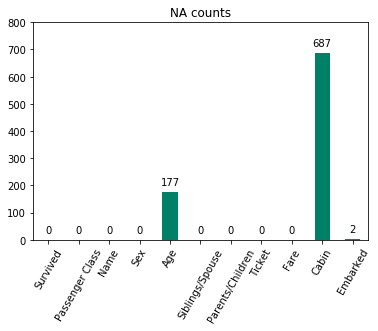

In [122]:
plt.cla()
plt.clf()
missing_data = raw_df.isnull().sum()
ax = missing_data.plot(kind = 'bar', rot=60, colormap='summer')
ax.set_ylim(0, 800) # we have 891 rows in total so 800 should be a good limit
plt.title("NA counts")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()   

Clearly Age, Cabin and Embarked has missing values We need to check if these variables are relevant to our analysis. If so, we need a strategy to fill those missing values. Else, we can drop them

<b>Age</b> : Likely to be relevant. We can fill the missing values with mean/median but that might be incorrect
<br>
<b>Cabin</b> : Cabin Number in itself is unlikely to be relevant to our analysis. But the cabin numbers indicate a pattern - a letter prefix (which might be the Deck number) and a suffix. The deck number might be relevant to our analysis (Passengers occupying deck closesnt to lifeboats might have better survival rate or so on)
<br>
<b>Embarked</b> : There are only 2 missing values. We can assume central tendency prevails and populate them with the mode (value with highest frequency)

Lets check the commonest embark point first

commonest embarked point :S


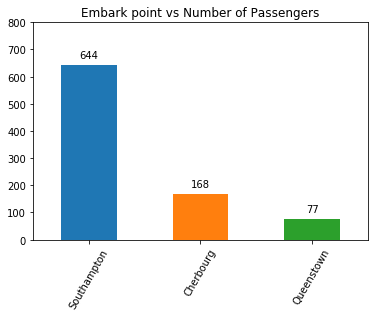

In [123]:
# check most frequent Embark point
plt.cla()
plt.clf()
embarked = raw_df["Embarked"].value_counts()
most_embarked = embarked.index[0]
print("commonest embarked point ",most_embarked,sep=":")
embarked.rename(embarked_dict, inplace=True)
ax = embarked.plot(kind='bar', rot=60)
ax.set_ylim(0, 800) # we have 891 rows in total so 800 should be a good limit
plt.title("Embark point vs Number of Passengers")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()


Clearly Southampton(S) was the most popular embarking point. So we can populate the missing values as 'S'

In [124]:
raw_df["Embarked"].fillna(value=most_embarked, inplace=True)

We can extract the salutation/titles (Ms, Mr, Master etc) from the names and use the mean age for a title to fill up the corresponding missing ages. It still is an approximation but its a better approximation that using overall mean/median value

In [125]:
# This if condition helps in case we run this block twice
if ('Title' not in raw_df.columns) :
    titles = pd.DataFrame(raw_df.apply(lambda x: (x["Name"].split(",")[1].split(".")[0]).strip(), axis=1), columns=["Title"])
    # show count of titles
    print("There are {} unique titles.".format(titles['Title'].nunique()))
    # show unique titles
    print("\n", titles['Title'].unique())
    print("\n")
    
    # group some of the titles together
    titles['Title'].replace({"Mlle":"Miss", "Ms" : "Miss", "Mme" : "Mrs" }, inplace=True)
    titles['Title'].replace(["Col","Major","Capt"],"Military", inplace=True)
    titles['Title'].replace(["the Countess","Lady","Sir","Jonkheer","Don"],"Nobles", inplace=True)
    titles['Title'].replace(["Rev"], "Priest", inplace=True)
    raw_df = raw_df.join(titles)

    
mean_ages = raw_df.groupby('Title')['Age'].mean()
print("Mean age per title",mean_ages,sep="\n")


There are 17 unique titles.

 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


Mean age per title
Title
Dr          42.000000
Master       4.574167
Military    56.600000
Miss        21.845638
Mr          32.368090
Mrs         35.788991
Nobles      41.600000
Priest      43.166667
Name: Age, dtype: float64


We can use this information to fillup the missing ages

In [126]:
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Dr'),'Age']=mean_ages.loc['Dr']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Master'),'Age']=mean_ages.loc['Master']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Military'),'Age']=mean_ages.loc['Military']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Miss'),'Age']=mean_ages.loc['Miss']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Mr'),'Age']=mean_ages.loc['Mr']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Mrs'),'Age']=mean_ages.loc['Mrs']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Nobles'),'Age']=mean_ages.loc['Nobles']
raw_df.loc[(raw_df['Age'].isnull()) & (raw_df['Title']=='Priest'),'Age']=mean_ages.loc['Priest']

Lets look at columns with null values again

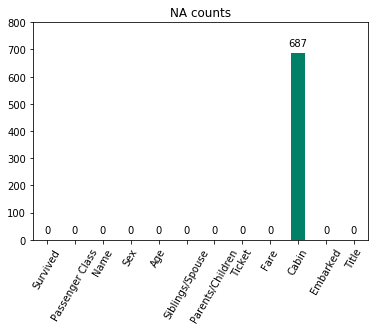

In [127]:
plt.cla()
plt.clf()
missing_data = raw_df.isnull().sum()
ax = missing_data.plot(kind = 'bar', rot=60, colormap='summer')
ax.set_ylim(0, 800) # we have 891 rows in total so 800 should be a good limit
plt.title("NA counts")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show() 

As expected, there's no row with missing Age or Embarked value anymore. Cabin still has nulls but we dont have any reliable strategy to fill up the cabin data

Now lets categorize age into groups. Lets get max and min age first

In [128]:
max_age = raw_df['Age'].max()
print("Max Age",max_age,sep=" : ")

min_age = raw_df['Age'].min()
print("Min Age",min_age,sep=" : ")

Max Age : 80.0
Min Age : 0.42


So we divide the passengers into following age groups : 
1. Child : 0 to 10<br>
2. Young Adult : 10 to 20<br>
3. Youth : 20 - 35<br>
4. Middle Aged : 35 - 60<br>
5. Senior : 60 and above<br>

In [129]:

bins = [0, 10, 20, 35, 60, 81]
raw_df['Age Group'] = pd.cut(raw_df['Age'], bins, labels = ['Child','Young Adult','Youth','Middle Aged','Senior'])

display(HTML(raw_df.head().to_html()))

,Survived,Passenger Class,Name,Sex,Age,Siblings/Spouse,Parents/Children,Ticket,Fare,Cabin,Embarked,Title,Age Group
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Youth
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Middle Aged
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Youth
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Youth
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Youth


Next we need to populate Family Size based on Siblings/Spouse and Parents/Children

Family Size should be [Siblings/Spouse] + [Parents/Children] + 1 (self)

In [130]:
# family size
fsize = pd.DataFrame(raw_df.apply(lambda x: x['Siblings/Spouse'] +x['Parents/Children'] + 1, axis=1), columns=["Family Size"])
# this if condition helps in case i run it twice
if ('Family Size' not in raw_df.columns) :
    raw_df = raw_df.join(fsize)

display(HTML(raw_df.head().to_html()))   

,Survived,Passenger Class,Name,Sex,Age,Siblings/Spouse,Parents/Children,Ticket,Fare,Cabin,Embarked,Title,Age Group,Family Size
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Youth,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Middle Aged,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Youth,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Youth,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Youth,1


Now we'll extract 'Is Employee' attribute values from data

We'll assume anybody with fare == 0 as employee

In [131]:
raw_df["Is Employee"] = raw_df["Fare"] == 0

Now we'll extract Deck information from cabin number

In [132]:
# extract deck info from cabin

# this if condition helps in case i run it twice
if ('Cabin' in raw_df.columns) :
    raw_df['Deck']=raw_df['Cabin'].str[0]
    
display(HTML(raw_df.head().to_html()))   

,Survived,Passenger Class,Name,Sex,Age,Siblings/Spouse,Parents/Children,Ticket,Fare,Cabin,Embarked,Title,Age Group,Family Size,Is Employee,Deck
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Youth,2,False,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Middle Aged,2,False,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Youth,1,False,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Youth,2,False,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Youth,1,False,NaN


<i>Do we have attributes conveying the same information ?</i>

We have two columns : <i>'Fare'</i> and <i>'Passenger Class'</i>. We need to check if both of them are conveying the same information (ie if they are perfectly or almost perfectly correlated) If they are conveying the same information, we can drop one of them while keeping the other

Lets get a correlation matrix between Fare and Passenger Class

<Figure size 432x288 with 0 Axes>

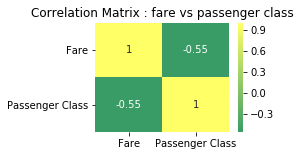

In [133]:
corr_matrix = raw_df[['Fare','Passenger Class']].corr().round(2)
plt.cla()
plt.clf()
f = plt.figure(figsize=(3,2))
sns.heatmap(corr_matrix, center=0, annot=True, cmap='summer')
plt.title("Correlation Matrix : fare vs passenger class")
plt.show()

The correlation value is negative which is expected (Class 3 fare will be lower than class 1 fare ... and so on) The correlation coefficient is reasonably high (0.55) but nowhere close to 1

Maybe, fare really means total fare and not necessarily fare per passenger. 

If thats the case, then for passengers travelling together, fare (and maybe ticket number as well) should be same.

In [134]:
fare_data = raw_df[['Passenger Class','Age','Family Size','Ticket','Fare']].copy()
fare_data = fare_data[fare_data['Family Size']>1]
fare_data = pd.DataFrame({'Count': fare_data.groupby(['Family Size', 'Ticket', 'Fare']).size()})
fare_data.sort_values(by = ['Ticket'])
display(HTML(fare_data.tail(20).to_html()))

Clearly there are a lot of cases where multiple people share the same ticket number and fare. So lets calculate fare per passenger

In [135]:
raw_df['Fare Per Passenger']=raw_df['Fare']/raw_df['Family Size']

Lets calculate the correlation matrix again - this time between Fare per Passenger and Family Size

<Figure size 432x288 with 0 Axes>

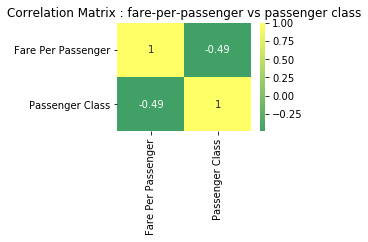

In [136]:
corr_matrix = raw_df[['Fare Per Passenger','Passenger Class']].corr().round(2)
plt.cla()
plt.clf()
f = plt.figure(figsize=(3,2))
sns.heatmap(corr_matrix, center=0, annot=True, cmap='summer')
plt.title("Correlation Matrix : fare-per-passenger vs passenger class")
plt.show()

Strangely the correlation has actually gone down which probably means there are a lot of ourliers in the Fare data

Lets look at a KDE plot for Fare Per Passenger

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Kaustubh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


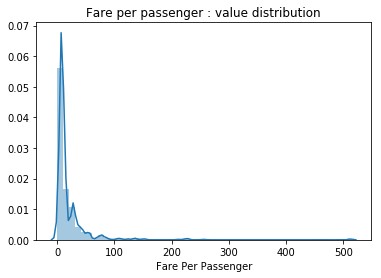

In [137]:
plt.cla()
plt.clf()
sns.distplot(raw_df['Fare Per Passenger'], kde=True)
plt.title("Fare per passenger : value distribution")
plt.show()

Clearly there are outlier values particularly towards the higher end of fares. Also lets look at this :
    

In [138]:
raw_df['Fare Per Passenger'].describe()

count    891.000000
mean      19.916375
std       35.841257
min        0.000000
25%        7.250000
50%        8.300000
75%       23.666667
max      512.329200
Name: Fare Per Passenger, dtype: float64

While 75 % of values are within 23.67, the max value is 512.32. Clearly this is an outlier.

Lets look at median fares per class


In [139]:
fare_1 = raw_df[raw_df["Passenger Class"] == 1]['Fare Per Passenger'].median()
print("Median 1st class fare :",fare_1)
fare_2 = raw_df[raw_df["Passenger Class"] == 2]['Fare Per Passenger'].median()
print("Median 2nd class fare :",fare_2)
fare_3 = raw_df[raw_df["Passenger Class"] == 3]['Fare Per Passenger'].median()
print("Median 3rd class fare :",fare_3)

Median 1st class fare : 33.760400000000004
Median 2nd class fare : 13.0
Median 3rd class fare : 7.75


How do we define outliers ? One easy way to define outliers would be to calculate the IQR and consider anything above 2.5 times IQR as an outlier



In [140]:
q25, q75 = np.percentile(raw_df['Fare Per Passenger'], 25), np.percentile(raw_df['Fare Per Passenger'], 75)
print("Inter Quartile Range :",q25, "-", q75)
iqr = q75 - q25
cut_off = iqr * 2.5
upper_limit = cut_off + q75
print("Upper cut off limit :",upper_limit)

Inter Quartile Range : 7.25 - 23.666666666666668
Upper cut off limit : 64.70833333333334


Now we can replace the outlier high values with median first class fare

In [143]:

raw_df.loc[raw_df['Fare Per Passenger']>upper_limit, 'Fare Per Passenger'] = np.nan
raw_df['Fare Per Passenger'].fillna(fare_1, inplace=True)


Now lets look at overall statistics and KDE curve

In [144]:
raw_df['Fare Per Passenger'].describe()

count    891.000000
mean      14.918177
std       12.473324
min        0.000000
25%        7.250000
50%        8.300000
75%       23.666667
max       56.929200
Name: Fare Per Passenger, dtype: float64

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Kaustubh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


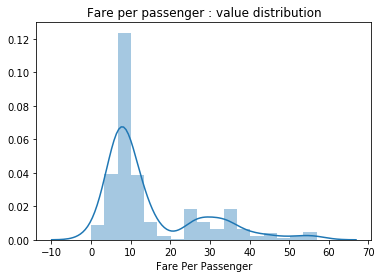

In [145]:
plt.cla()
plt.clf()
sns.distplot(raw_df['Fare Per Passenger'], kde=True)
plt.title("Fare per passenger : value distribution")
plt.show()

Now the fare distribution looks a lot less skewed

Calculating the correlation matrix again

<Figure size 432x288 with 0 Axes>

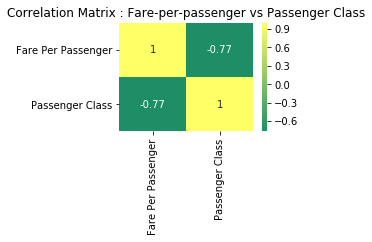

In [146]:
corr_matrix = raw_df[['Fare Per Passenger','Passenger Class']].corr().round(2)
plt.cla()
plt.clf()
f = plt.figure(figsize=(3,2))
sns.heatmap(corr_matrix, center=0, annot=True, cmap='summer')
plt.title("Correlation Matrix : Fare-per-passenger vs Passenger Class")
plt.show()

If we calculate correlation using Spearman approach instead of Pearson approoach, we get similar numbers as well

In [147]:
print(spearmanr(raw_df['Fare Per Passenger'], raw_df['Passenger Class'])[0])

-0.765487747937759


Clearly Fare/Fare per Passenger and Passenger Class are highly correlated (0.77) and are probably representing the same attribute. So we can drop Fare and Fare per passenger

Next let's see if we can drop a few other columns off our dataset

<i>Were people treated differently based on title/salutation? Did nobles or doctors or military personnel have a better chance of survival ?</i>

We can do a rudimentary analysis to check if Titles were relevant to survival. If not we can drop the Title information from the dataset

<Figure size 432x288 with 0 Axes>

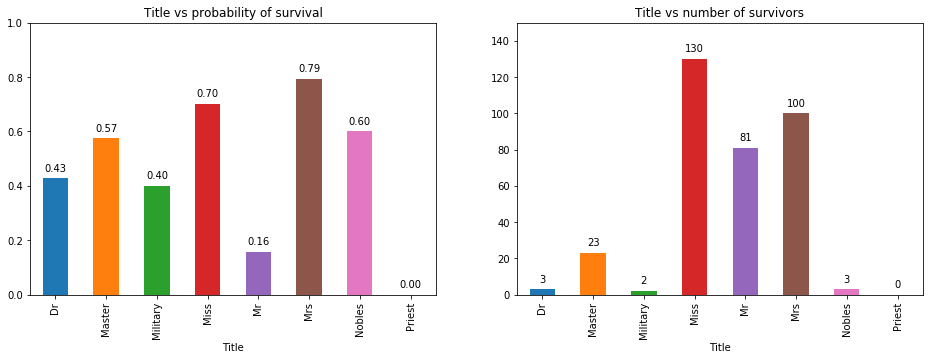

In [148]:

plt.cla()
plt.clf()
f, axes = plt.subplots(1, 2 , figsize=(16,5))

grouped_by_titles = raw_df.groupby('Title').agg('mean')
ax0 = grouped_by_titles['Survived'].plot(kind='bar', ax = axes[0])
ax0.set_ylim(0, 1) 
ax0.set_title('Title vs probability of survival')
for p in ax0.patches:
    ax0.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

summed_by_title = raw_df.groupby('Title').agg('sum')
ax1 = summed_by_title['Survived'].plot(kind='bar', ax = axes[1])
ax1.set_ylim(0,150) 
ax1.set_title('Title vs number of survivors')
for p in ax1.patches:
    ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')    
plt.show()

None of the priests survived. Nobles do have a higher probability of survival. However because of the extremely small absolute number of nobles/priests/doctors/military personnel, the data may be skewed.

Hence we can drop off title data from analysis

Is Deck info relevant to survival ? If not then we can drop it from the data

<Figure size 432x288 with 0 Axes>

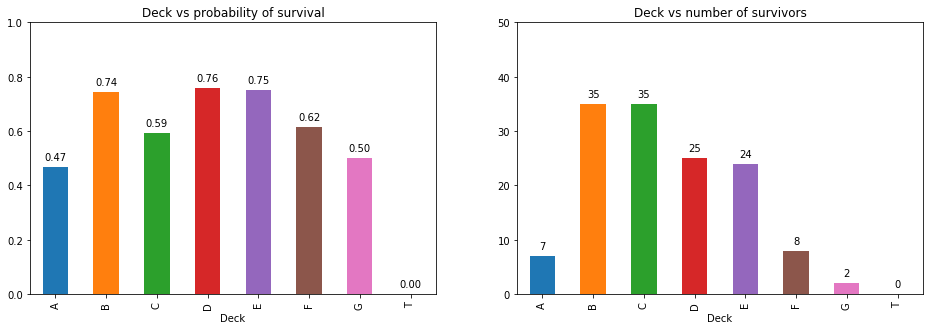

In [149]:
plt.cla()
plt.clf()
f, axes = plt.subplots(1, 2 , figsize=(16,5))

grouped_by_deck = raw_df.groupby('Deck').agg('mean')
ax0 = grouped_by_deck['Survived'].plot(kind='bar', ax = axes[0])
ax0.set_ylim(0, 1) 
ax0.set_title('Deck vs probability of survival')
for p in ax0.patches:
    ax0.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

summed_by_deck = raw_df.groupby('Deck').agg('sum')
ax1 = summed_by_deck['Survived'].plot(kind='bar', ax = axes[1])
ax1.set_ylim(0,50) 
ax1.set_title('Deck vs number of survivors')
for p in ax1.patches:
    ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')    
plt.show()

There might be some correlation between Deck Number and Survival but the absolute number of survivors indicate that the sample size is too small

77 % of values in the column have no data. So, we are working on a small subset of data and hence our analysis can be skewed

The missing cabin ( and hence deck) info might be genuine data (maybe only certain category of passengers had access to personal cabin) or it might be just a case of bad/missing data. Let's see if we can draw some conclusions based on the data

Lets generate a correlation matrix between passenger class and deck

<Figure size 432x288 with 0 Axes>

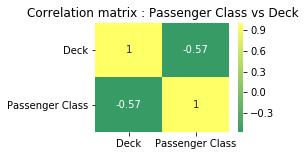

In [151]:
copy_df = raw_df[['Passenger Class','Deck']].copy()
copy_df['Deck'].fillna('U', inplace=True)
copy_df['Deck']=copy_df['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':0})
corr_matrix = copy_df[['Deck','Passenger Class']].corr().round(2)
plt.cla()
plt.clf()
f = plt.figure(figsize=(3,2))
sns.heatmap(corr_matrix, center=0, annot=True, cmap='summer')
plt.title("Correlation matrix : Passenger Class vs Deck")
plt.show()

Lets look at another view of the data

In [152]:
copy_df = raw_df[['Passenger Class','Deck']].copy()
copy_df['Deck'].fillna('U', inplace=True)
display(HTML(pd.DataFrame({'Count': copy_df.groupby(['Deck','Passenger Class']).size()}).to_html()))

While the correlation matrix suggests some correlation between deck and passenger class, the above view clearly shows that cabin and deck data is available mostly for first class passengers

This combined with the fact that cabin info is missing for  77 % of passengers suggests that sample size is too small and highly skewed

So we can drop off Deck and Cabin info from analysis

## Attributes dropped from analysis

So we are dropping off the following attributes :

Built-in attributes :
<br>
1. Name : Name in itself has no impact on survival. And we have already captured the title as a separate attribute
<br>
2. Ticket : There's no pattern to engineer additional attributes out of it. Ticket number in itself should not impact survival
<br>
3. Cabin : Extracted Deck information separately. Also Cabin data is missing for 77 % passengers and available mostly for first class passengers. So sample size is too small and highly skewed
<br>
4. Fare : Extracted Fare per Passenger as a separate attribute

Engineered attributes:
<br>
1. Deck : Deck has some correlation with survival but deck data is missing for 77 % passengers and available mostly for first class passengers. So sample size is too small and highly skewed
<br>
2. Title : Part of Title inofrmation is captured in other information like Sex and Age Group. Special Titles might have correlation with survival but the size of the data is too small
<br>
3. Fare per Passenger : Because it has very high correlation with Passenger Class (0.77), its probably representing the same information as Passenger Class
<br>

In [154]:
print("All built-in and engineered columns")
display(HTML(raw_df.head().to_html()))  

df = raw_df.drop(['Name','Ticket','Cabin','Fare','Title','Deck','Fare Per Passenger'], axis=1)

print("After dropping columns")
display(HTML(df.head().to_html())) 

All built-in and engineered columns


,Survived,Passenger Class,Name,Sex,Age,Siblings/Spouse,Parents/Children,Ticket,Fare,Cabin,Embarked,Title,Age Group,Family Size,Is Employee,Deck,Fare Per Passenger
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Youth,2,False,NaN,3.62500
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Middle Aged,2,False,C,35.64165
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Youth,1,False,NaN,7.92500
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Youth,2,False,C,26.55000
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Youth,1,False,NaN,8.05000


After dropping columns


,Survived,Passenger Class,Sex,Age,Siblings/Spouse,Parents/Children,Embarked,Age Group,Family Size,Is Employee
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,S,Youth,2,False
2,1,1,female,38.0,1,0,C,Middle Aged,2,False
3,1,3,female,26.0,0,0,S,Youth,1,False
4,1,1,female,35.0,1,0,S,Youth,2,False
5,0,3,male,35.0,0,0,S,Youth,1,False


## Survival analysis

Our aim to to come up with factors that influenced probability of survival

Overall survival data looks like this :

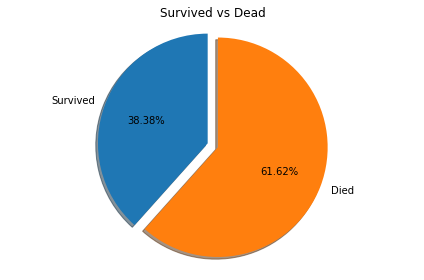

In [155]:
plt.cla()
plt.clf()
ax = plt.gca()

labels = ['Survived','Died']
survived_count = df[df['Survived'] == 1].shape[0]
dead_count = df[df['Survived'] == 0].shape[0]
total = df.shape[0]
abs_data = [survived_count, dead_count]
prob_data = [survived_count/total, dead_count/total]
explode = (0, 0.1)


ax.pie(abs_data, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title("Survived vs Dead")

plt.tight_layout()
plt.show()

The varaiables to analyze are :

Passenger Class
<br>
Sex
<br>
Age
<br>
Siblings/Spouse
<br>
Parents/Children
<br>
Embarked
<br>
Fare Per Passenger
<br>
Family Size
<br>
Child/Adult
<p>
Lets look at distribution curves for this variables and check if we have reasonably sized data for analysis

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Kaustubh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

<Figure size 1800x1440 with 0 Axes>

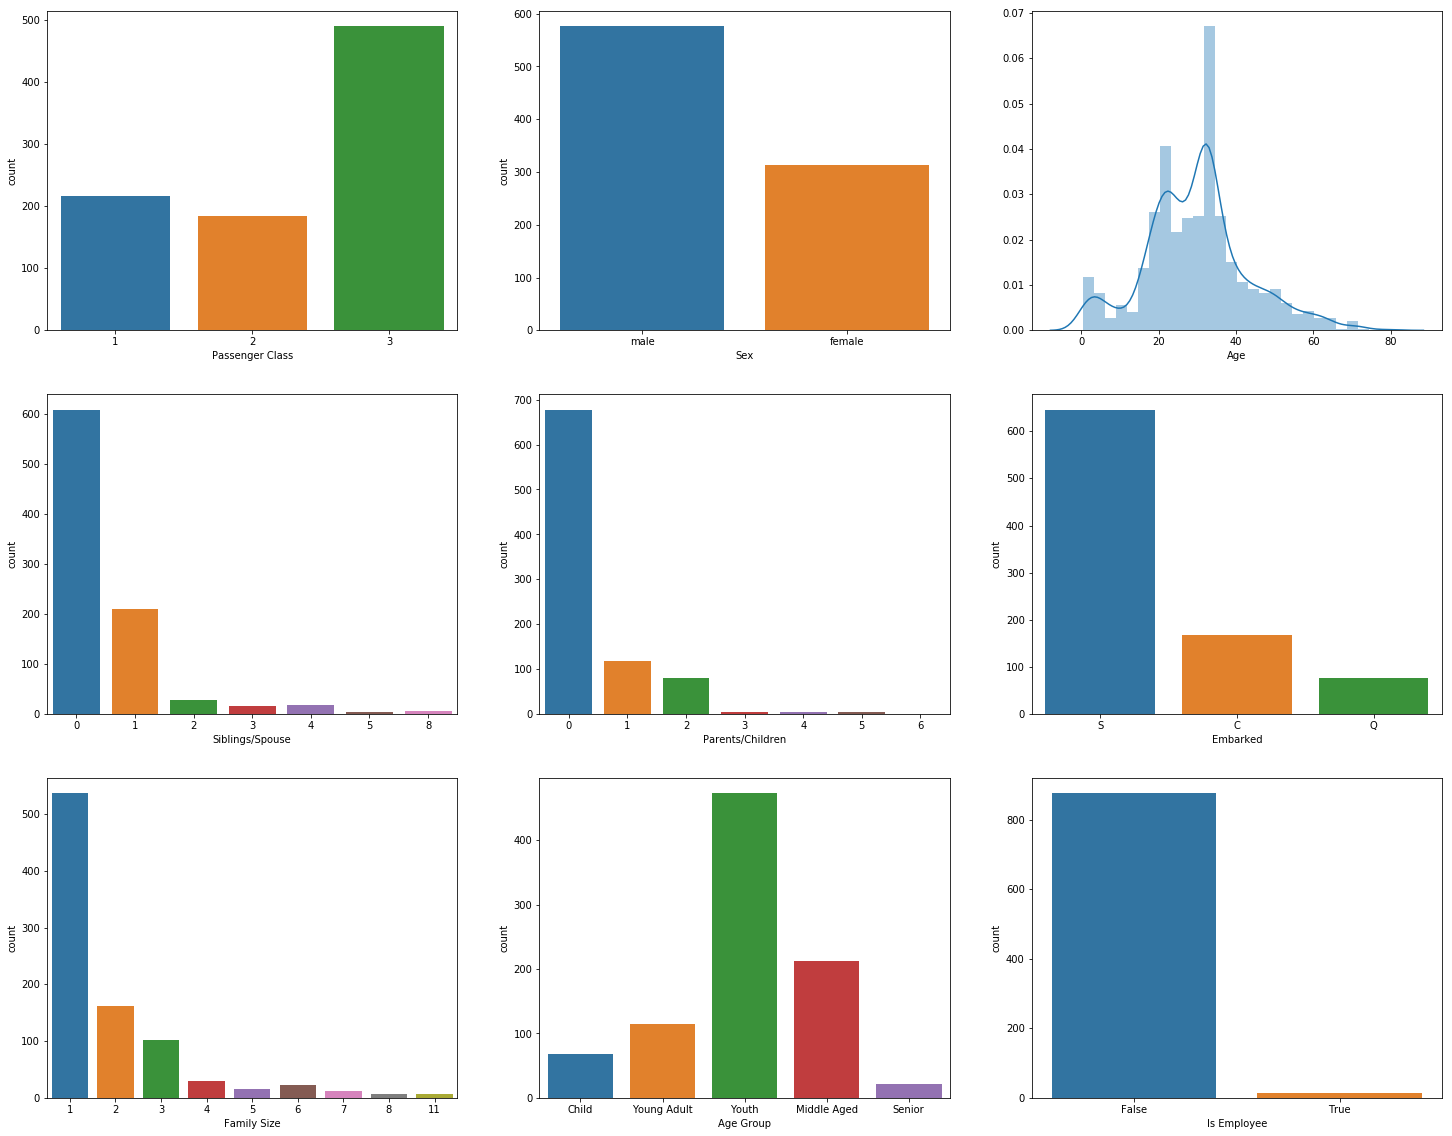

In [158]:
plt.cla()
plt.clf()
fig, axes = plt.subplots(3,3, figsize=(25, 20))

sns.countplot('Passenger Class', data=df, ax=axes[0,0])
sns.countplot('Sex', data=df, ax=axes[0,1])
sns.distplot(df['Age'], kde=True, ax=axes[0,2])
sns.countplot('Siblings/Spouse', data=df, ax=axes[1,0])
sns.countplot('Parents/Children', data=df, ax=axes[1,1])
sns.countplot('Embarked', data=df, ax=axes[1,2])
sns.countplot('Family Size', data=df, ax=axes[2,0])
sns.countplot('Age Group', data=df, ax=axes[2,1])
sns.countplot('Is Employee', data=df, ax=axes[2,2])

plt.show()

From the plots above we can clearly see that there's enough data in our dataset to analyze impact of each of these variables on survival ( Except maybe Is Employee - for which data is highly skewed)

Now lets look at plots of each of these variables against survival data

<Figure size 432x288 with 0 Axes>

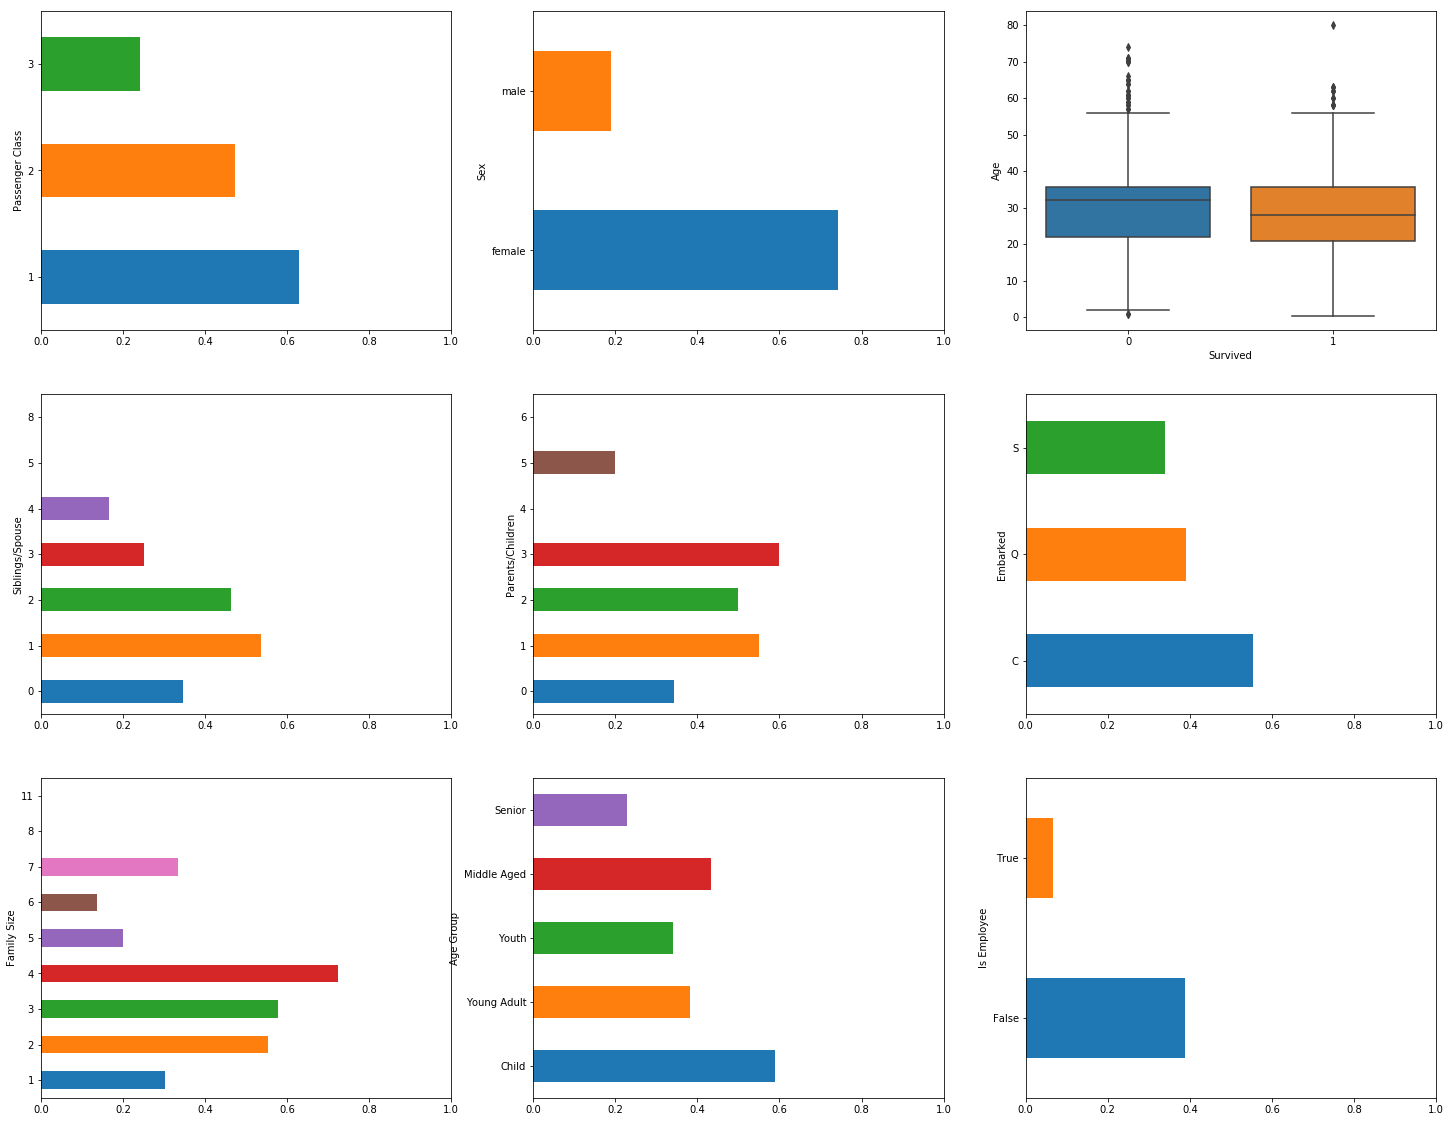

In [159]:
plt.cla()
plt.clf()
fig, axes = plt.subplots(3,3, figsize=(25, 20))
df.groupby('Passenger Class')['Survived'].mean().plot(kind="barh", ax=axes[0,0], xlim=(0,1))
df.groupby('Sex')['Survived'].mean().plot(kind="barh", ax=axes[0,1], xlim=(0,1))
sns.boxplot(x="Survived", y="Age", data=df, ax=axes[0,2])
df.groupby('Siblings/Spouse')['Survived'].mean().plot(kind="barh", ax=axes[1,0], xlim=(0,1))
df.groupby('Parents/Children')['Survived'].mean().plot(kind="barh", ax=axes[1,1], xlim=(0,1))
df.groupby('Embarked')['Survived'].mean().plot(kind="barh", ax=axes[1,2], xlim=(0,1))
df.groupby('Family Size')['Survived'].mean().plot(kind="barh", ax=axes[2,0], xlim=(0,1))
df.groupby('Age Group')['Survived'].mean().plot(kind="barh", ax=axes[2,1], xlim=(0,1))
df.groupby('Is Employee')['Survived'].mean().plot(kind="barh", ax=axes[2,2], xlim=(0,1))
plt.show()

Also lets look at a heatmap showing correlation matrix between the variables

In order to do that we need to replace textual categorial data with their numerical equivalents like this <br>
sex = {"male": 1, "female": -1}<br>
embarked = {"S":0, "Q":1, "C":2}<br>
agegroup = {'Child':1, 'Young Adult':2, 'Youth':3, 'Middle Aged':4, 'Senior':5}  

<Figure size 432x288 with 0 Axes>

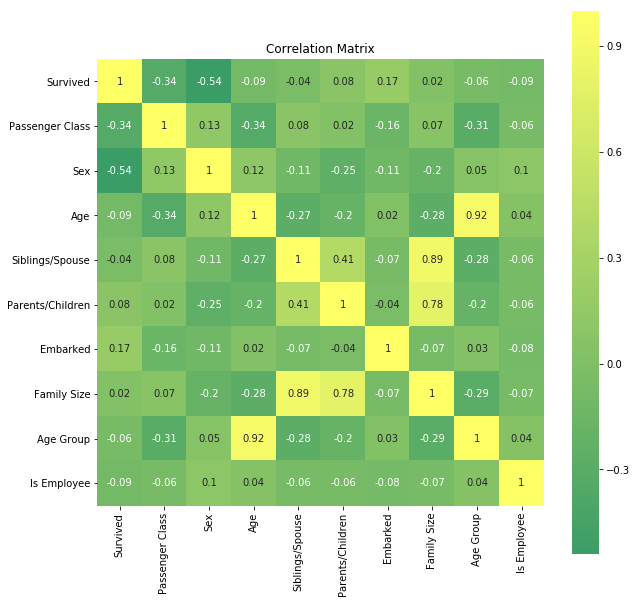

In [163]:
plt.cla()
plt.clf()

#in order to generate heatmap we need numeric values
genders = {"male": 1, "female": -1}
embark_numeric = {"S":0, "Q":1, "C":2}
age_group =  {'Child':1, 'Young Adult':2, 'Youth':3, 'Middle Aged':4, 'Senior':5}   

df_num = df.copy()
df_num["Sex"] = df["Sex"].map(genders)
df_num["Embarked"]=df["Embarked"].map(embark_numeric)
df_num["Age Group"]=df["Age Group"].map(age_group)

corr_matrix = df_num[['Survived','Passenger Class','Sex','Age','Siblings/Spouse','Parents/Children','Embarked','Family Size', 'Age Group','Is Employee']].corr().round(2)

fig = plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, annot=True, center=0, square=True, cmap="summer")
plt.title("Correlation Matrix")
plt.show()

Clearly the 2 most significant (in-terms of absolute value of correlation coefficient) parameters inflencing survival are :

1. Sex (0.54)
<br>
2. Passenger Class (0.34)
<br>

Now, lets look at each of these factors in detail

A. Sex



In [164]:
sex_vs_survived = pd.DataFrame({'Count': df.groupby(['Sex','Survived']).size()})
sex_vs_survived_sum = sex_vs_survived.sum(level=0, axis=0)
sex_vs_survived['Probability'] = 0
sex_vs_survived.loc[('female', 0),'Probability']=sex_vs_survived.loc[('female', 0),'Count']/sex_vs_survived_sum.loc['female', 'Count']
sex_vs_survived.loc[('female', 1),'Probability']=sex_vs_survived.loc[('female', 1),'Count']/sex_vs_survived_sum.loc['female', 'Count']
sex_vs_survived.loc[('male', 0),'Probability']=sex_vs_survived.loc[('male', 0),'Count']/sex_vs_survived_sum.loc['male', 'Count']
sex_vs_survived.loc[('male', 1),'Probability']=sex_vs_survived.loc[('male', 1),'Count']/sex_vs_survived_sum.loc['male', 'Count']
display(HTML(sex_vs_survived.to_html()))

Clearly women had a better shot at survival as compared to men. Women lead mean both in terms of absolute number as well as percentage of survivors

Lets look at a graphical representation of this data

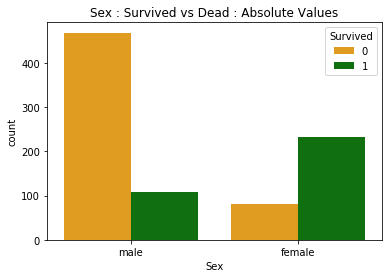

In [169]:
plt.cla()
plt.clf()
survival_palette = {1: "green", 0: "orange"} # Color map for visualization
sns.countplot('Sex', hue='Survived', data=df, palette=survival_palette)
plt.title('Sex : Survived vs Dead : Absolute Values')
plt.show()

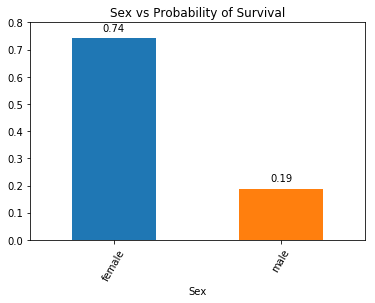

In [170]:
plt.cla()
plt.clf()

plt.title("Sex vs Probability of Survival")
grouped_by_class = df.groupby('Sex').agg('mean')
ax = grouped_by_class["Survived"].plot(kind='bar', rot=60)
ax.set_ylim(0, 0.8) 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

B. Passenger Class

Lets look at number of Survived/Dead passengers per class

In [171]:
pclass_vs_survived = pd.DataFrame({'Count': df.groupby(['Passenger Class','Survived']).size()})
pclass_vs_survived_sum = pclass_vs_survived.sum(level=0, axis=0)
pclass_vs_survived['Probability'] = 0
pclass_vs_survived.loc[(1, 0),'Probability']=pclass_vs_survived.loc[(1, 0),'Count']/pclass_vs_survived_sum.loc[1, 'Count']
pclass_vs_survived.loc[(1, 1),'Probability']=pclass_vs_survived.loc[(1, 1),'Count']/pclass_vs_survived_sum.loc[1, 'Count']
pclass_vs_survived.loc[(2, 0),'Probability']=pclass_vs_survived.loc[(2, 0),'Count']/pclass_vs_survived_sum.loc[2, 'Count']
pclass_vs_survived.loc[(2, 1),'Probability']=pclass_vs_survived.loc[(2, 1),'Count']/pclass_vs_survived_sum.loc[2, 'Count']
pclass_vs_survived.loc[(3, 0),'Probability']=pclass_vs_survived.loc[(3, 0),'Count']/pclass_vs_survived_sum.loc[3, 'Count']
pclass_vs_survived.loc[(3, 1),'Probability']=pclass_vs_survived.loc[(3, 1),'Count']/pclass_vs_survived_sum.loc[3, 'Count']
display(HTML(pclass_vs_survived.to_html()))

Clearly first and second class passengers had a significantly higher chance of survival as compared to 3rd class passengers

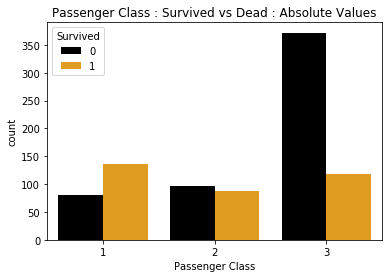

In [172]:
plt.cla()
plt.clf()

survival_palette = {0: "black", 1: "orange"} # Color map for visualization

sns.countplot('Passenger Class', hue='Survived', data=df, palette=survival_palette)
plt.title('Passenger Class : Survived vs Dead : Absolute Values')
plt.show()

From this diagram it is not very clear because of relatively low number of first and second class passengers. Lets look at another view of the data

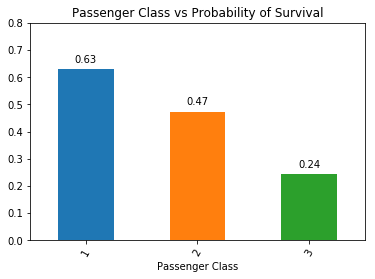

In [173]:
plt.cla()
plt.clf()

plt.title("Passenger Class vs Probability of Survival")
grouped_by_class = df.groupby('Passenger Class').agg('mean')
ax = grouped_by_class["Survived"].plot(kind='bar', rot=60)
ax.set_ylim(0, 0.8) 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

This clearly indicates that 1st and 2nd class passengers were given priority during rescue

Now lets take a look at other minor features :

Age<br>
Age Group<br>
Siblings/Spouse<br>
Parents/Children<br>
Family Size<br>
Embarked

A. Age and Age Group

Maybe children were treated with priority irrespective of gender and passenger class. Lets see if the data confirms this

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

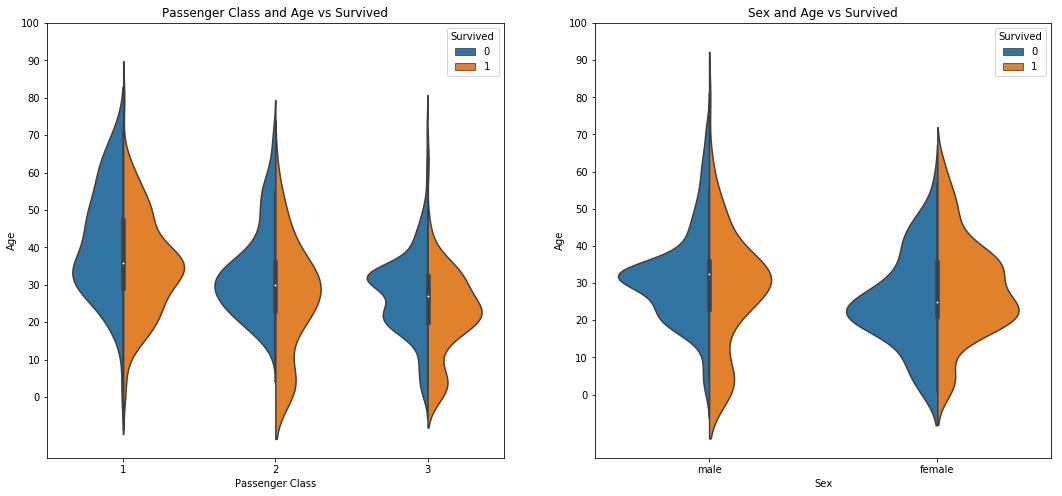

In [174]:
# Maybe children were treated differently irrespective of gender ?
plt.cla()
plt.clf()
f,ax=plt.subplots(1,2,figsize=(18,8))

sns.violinplot('Passenger Class','Age',hue='Survived',data=df ,split=True ,ax=ax[0])
ax[0].set_title('Passenger Class and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex","Age", hue="Survived", data=df ,split=True ,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

Clearly children under age of 10 have a relatively high survival rate (more children survived than died) irrespective of class

Male children under age 10 have high survival rate (more children survived than died) but thats not the case with female children

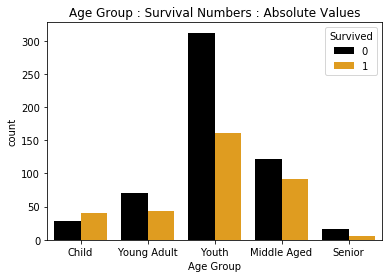

In [175]:
plt.cla()
plt.clf()

survival_palette = {0: "black", 1: "orange"} # Color map for visualization

sns.countplot('Age Group', hue='Survived', data=df, palette=survival_palette)
plt.title('Age Group : Survival Numbers : Absolute Values')
plt.show()

Clearly more young people died than survived

This plot doesnt tell us much about survival of children because there are so few children compared to number of adults

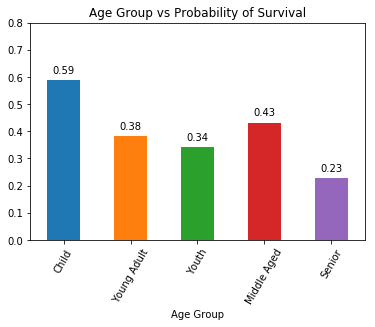

In [176]:
plt.cla()
plt.clf()

plt.title("Age Group vs Probability of Survival")
grouped_by_child_adult = df.groupby('Age Group').agg('mean')
ax = grouped_by_child_adult["Survived"].plot(kind='bar', rot=60)
ax.set_ylim(0, 0.8) 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

Clearly children were much more likely to survive than adults

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


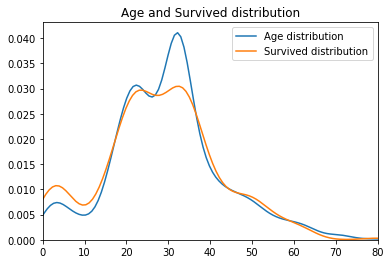

In [177]:
plt.cla()
plt.clf()
sns.kdeplot(df['Age'], shade=False, label='Age distribution')
sns.kdeplot(df.loc[df['Survived']==1, 'Age'], shade=False, label='Survived distribution') 
plt.title("Age and Survived distribution")
plt.xlim(0,80)
plt.show() 

Overall Age doesnt seem to have much impact on survival except for two relative outliers :

1. children were more likely to survive<br>
2. young people were more likely to die

B. Family Size/Parents and Children/Siblings and Spouse

<Figure size 432x288 with 0 Axes>

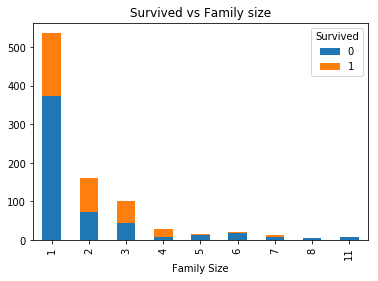

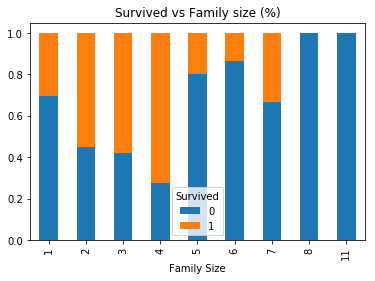

In [178]:
plt.cla()
plt.clf()
pd.crosstab(df['Family Size'], df['Survived']).plot(kind='bar', stacked=True, title="Survived vs Family size")
pd.crosstab(df['Family Size'], df['Survived'], normalize='index').plot(kind='bar', stacked=True, title="Survived vs Family size (%)")
plt.show() 

Even though family size overall has low correlation with survival, it seems that for families with 1 to 4 people, larger family size increases survival rates. But for families of 5 and up, survival rates is much lower.

Lets visualize the family data in combination with Sex and Passenger Class

<Figure size 432x288 with 0 Axes>

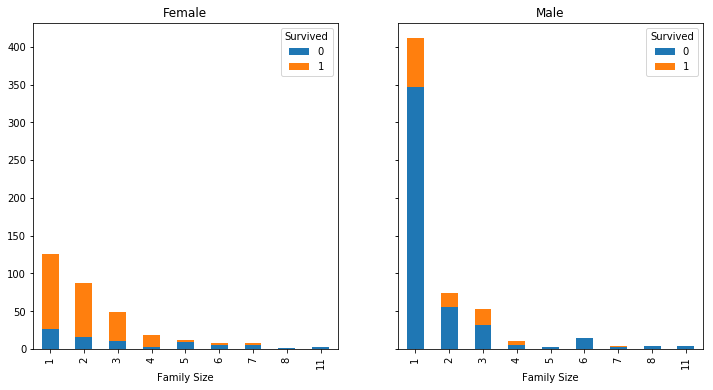

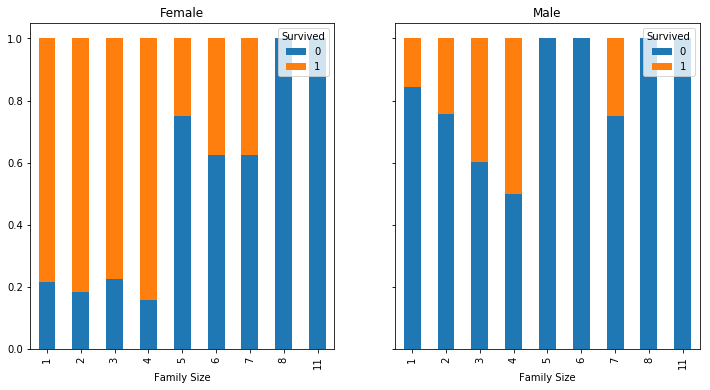

In [179]:
plt.cla()
plt.clf()

female = df[df['Sex'] == 'female']
male = df[df['Sex'] == 'male']

f,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)
pd.crosstab(female['Family Size'], female['Survived']).plot(kind='bar', stacked=True, title="Female", ax=ax[0])
pd.crosstab(male['Family Size'], male['Survived']).plot(kind='bar', stacked=True, title="Male", ax=ax[1])

f,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)
pd.crosstab(female['Family Size'], female['Survived'], normalize = 'index').plot(kind='bar', stacked=True, title="Female", ax=ax[0])
pd.crosstab(male['Family Size'], male['Survived'], normalize = 'index').plot(kind='bar', stacked=True, title="Male", ax=ax[1])


plt.show()

Clearly for both sex, family sizes of 5 and up lead to low survival rates. For females in families up to 4, the survival rate is about 80%, regardless of family size. For males in families up to 4, the survival rate increases with family size

<Figure size 432x288 with 0 Axes>

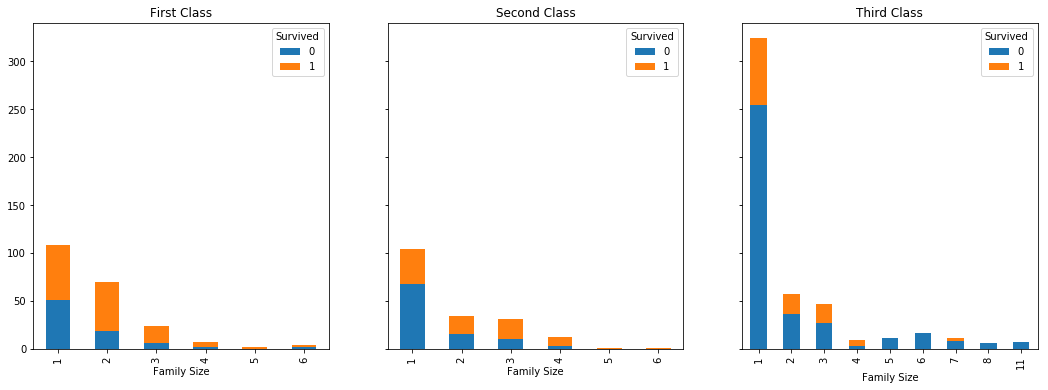

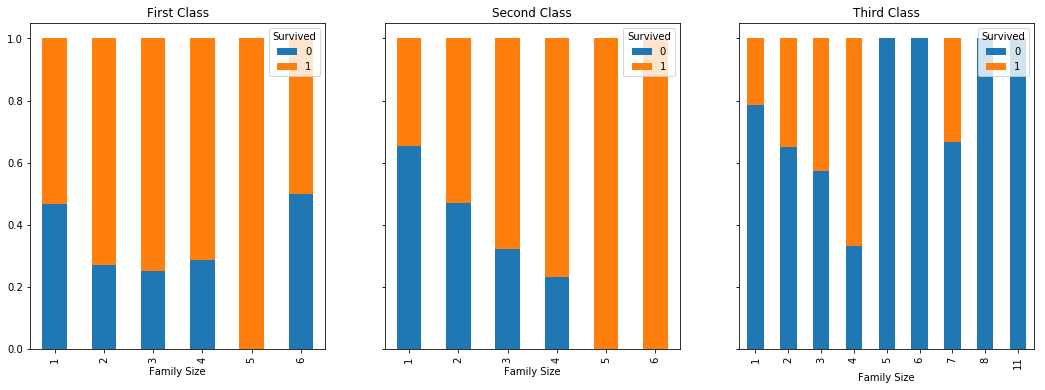

In [180]:
plt.cla()
plt.clf()

class1 = df[df['Passenger Class'] == 1]
class2 = df[df['Passenger Class'] == 2]
class3 = df[df['Passenger Class'] == 3]

f,ax=plt.subplots(1,3,figsize=(18,6),sharey=True)
pd.crosstab(class1['Family Size'], class1['Survived']).plot(kind='bar', stacked=True, title="First Class", ax=ax[0])
pd.crosstab(class2['Family Size'], class2['Survived']).plot(kind='bar', stacked=True, title="Second Class", ax=ax[1])
pd.crosstab(class3['Family Size'], class3['Survived']).plot(kind='bar', stacked=True, title="Third Class", ax=ax[2])

f,ax=plt.subplots(1,3,figsize=(18,6),sharey=True)
pd.crosstab(class1['Family Size'], class1['Survived'], normalize = 'index').plot(kind='bar', stacked=True, title="First Class", ax=ax[0])
pd.crosstab(class2['Family Size'], class2['Survived'], normalize = 'index').plot(kind='bar', stacked=True, title="Second Class", ax=ax[1])
pd.crosstab(class3['Family Size'], class3['Survived'], normalize = 'index').plot(kind='bar', stacked=True, title="Third Class", ax=ax[2])


plt.show()

Interestingly almost none of the first or second class passengers travelled with large family For all classes, probability of survival increases with increase in family size upto a size of 4 Irrespective of family size, first class passengers have more than 50 % chance of survival

C. Embarked

<Figure size 432x288 with 0 Axes>

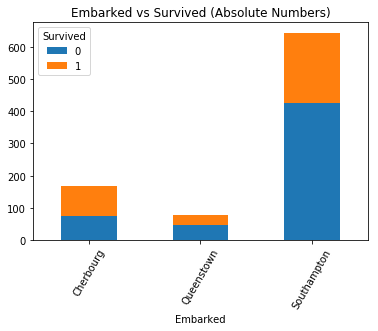

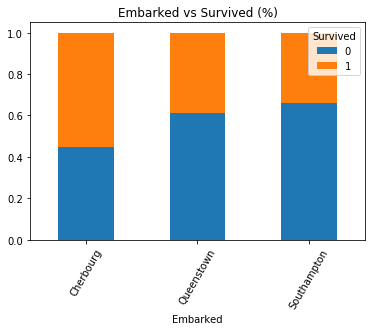

In [181]:
plt.cla()
plt.clf()
pd.crosstab(df['Embarked'].map(embarked_dict), df['Survived']).plot(kind='bar', stacked=True, title="Embarked vs Survived (Absolute Numbers)", rot=60)
pd.crosstab(df['Embarked'].map(embarked_dict), df['Survived'], normalize='index').plot(kind='bar', stacked=True, title="Embarked vs Survived (%)", rot=60)
plt.show() 

Lets visualize Embarked data in combination with Sex and Passenger Class

C:\Users\Kaustubh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

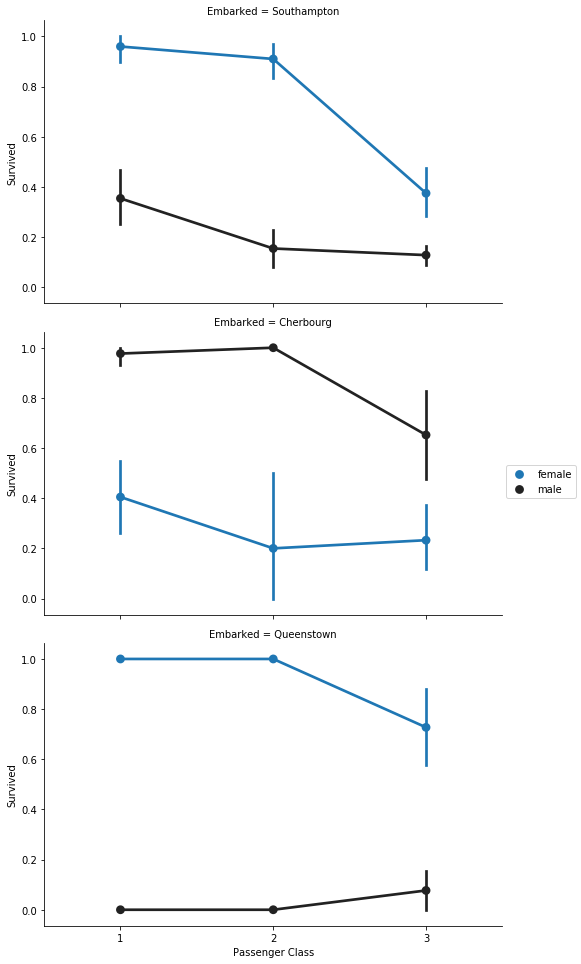

In [182]:
plt.cla()
plt.clf()
df1 = df.copy()
df1['Embarked'] = df['Embarked'].map(embarked_dict)
fg = sns.FacetGrid(df1, row='Embarked', size=4.5, aspect=1.6)
fg.map(sns.pointplot, 'Passenger Class', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
fg.add_legend()
plt.show()

Interestingly, women boarding at Queenstown and Southampton fared better than men at survival. But the opposite is true for Cherbourg Men borading at Cherbourg survived whereas men boarding at Southampton and Queensbury mostly perished

D. Is Employee

In [183]:
iscrew_vs_survived = pd.DataFrame({'Count': df.groupby(['Is Employee','Survived']).size()})
iscrew_vs_survived_sum = iscrew_vs_survived.sum(level=0, axis=0)
iscrew_vs_survived['Probability'] = 0
iscrew_vs_survived.loc[(True, 0),'Probability']=iscrew_vs_survived.loc[(True, 0),'Count']/iscrew_vs_survived_sum.loc[True, 'Count']
iscrew_vs_survived.loc[(True, 1),'Probability']=iscrew_vs_survived.loc[(True, 1),'Count']/iscrew_vs_survived_sum.loc[True, 'Count']
iscrew_vs_survived.loc[(False, 0),'Probability']=iscrew_vs_survived.loc[(False, 0),'Count']/iscrew_vs_survived_sum.loc[False, 'Count']
iscrew_vs_survived.loc[(False, 1),'Probability']=iscrew_vs_survived.loc[(False, 1),'Count']/iscrew_vs_survived_sum.loc[False, 'Count']
display(HTML(iscrew_vs_survived.to_html()))

Clearly most of the White Star Line employees perished. But the overall number of White Star Line employees/officials that we detected is too small to make a meaningful conclusion

## Conclusion

Overall, the main factors that impacted survival are :
    1. Sex : Women fared better than men
    2. Passenger Class : Passengers in first class were more likely to survive.
    3. Age Group : Children were more likely to survive compared to adults. Young people were more likely to die
    4. Embarked : Women boarding from Queenstown/Southampton mostly survived, while men boarding from Cherbourg fared better than others
    5. Family Size : Larger the family better the survival rate but for not for too large families (> 4)